In [7]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Poisson
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

% matplotlib inline

In [8]:
# Create a Dataframe and drop extra column
df = pd.read_csv('./data/seattle_911_prepped.csv', low_memory=False)
df.drop(['Unnamed: 0'], axis=1, inplace=True)

df_no_out = pd.read_csv('./data/seattle_911_prepped_no_out.csv', low_memory=False)
df_no_out.drop(['Unnamed: 0'], axis=1, inplace=True)

In [4]:
df.head()

,Address,Type,Datetime,Latitude,Longitude,Report Location,Incident Number,dt_crop,date,time,...,day_num,neighborhood,zone1,zone2,zone3,zone4,zone5,zone6,zone7,seasonality
0,11747 Bartlett Av Ne,Medic Response,2010-06-29 08:00:00,47.713787,-122.283848,NaN,NaN,06/29/2010 08:00:00 AM,2010-06-29,08:00:00,...,0,Matthews Beach,0,1,0,0,0,0,0,1.824157
1,700 6th Av S,Aid Response,2010-06-29 07:49:00,47.596676,-122.326370,NaN,NaN,06/29/2010 07:49:00 AM,2010-06-29,07:49:00,...,0,International District,0,0,0,0,1,0,0,1.824157
2,7751 26th Av Nw,Aid Response,2010-06-29 07:49:00,47.685264,-122.389777,NaN,NaN,06/29/2010 07:49:00 AM,2010-06-29,07:49:00,...,0,Loyal Heights,1,0,0,0,0,0,0,1.824157
3,5241 33rd Av S,Aid Response,2010-06-29 07:50:00,47.554718,-122.290486,NaN,NaN,06/29/2010 07:50:00 AM,2010-06-29,07:50:00,...,0,Mid-Beacon Hill,0,0,0,0,0,0,1,1.824157
4,509 3rd Av,Auto Fire Alarm,2010-06-29 07:50:00,47.602114,-122.330809,NaN,NaN,06/29/2010 07:50:00 AM,2010-06-29,07:50:00,...,0,Pioneer Square,0,0,0,0,1,0,0,1.824157


In [9]:
df2 = df.drop(labels=(['Address', 'Type', 'Report Location', 'Incident Number',
                 'dt_crop', 'neighborhood', 'date2', 'time2', 'weekday',
                 'Latitude', 'Longitude', 'time', 'Datetime', 'date']), axis=1)
df2_no_out = df_no_out.drop(labels=(['Address', 'Type', 'Report Location', 'Incident Number',
                 'dt_crop', 'neighborhood', 'date2', 'time2', 'weekday',
                 'Latitude', 'Longitude', 'time', 'Datetime', 'date']), axis=1)
df2.head()

,mariners_home,seahawks_home,sounders_home,trav_holiday,dang_holiday,night,Monday,Saturday,Sunday,Thursday,...,Wednesday,day_num,zone1,zone2,zone3,zone4,zone5,zone6,zone7,seasonality
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1.824157
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1.824157
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1.824157
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1.824157
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1.824157


In [10]:
df2.to_csv('./data/model_data.csv')
df2_no_out.to_csv('./data/model_data_no_out.csv')

In [11]:
# R used to fix dataframe for Poisson model
df3 = pd.read_csv('./data/model_data_counted_no_out.csv', low_memory=False)
df3.drop(['Unnamed: 0'], axis=1, inplace=True)

In [12]:
df3.head()

,mariners_home,seahawks_home,sounders_home,trav_holiday,dang_holiday,night,Monday,Saturday,Sunday,Thursday,...,day_num,zone1,zone2,zone3,zone4,zone5,zone6,zone7,seasonality,freq
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1.824157,20
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1.824157,35
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1.824157,30
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1.824157,18
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1.824157,15


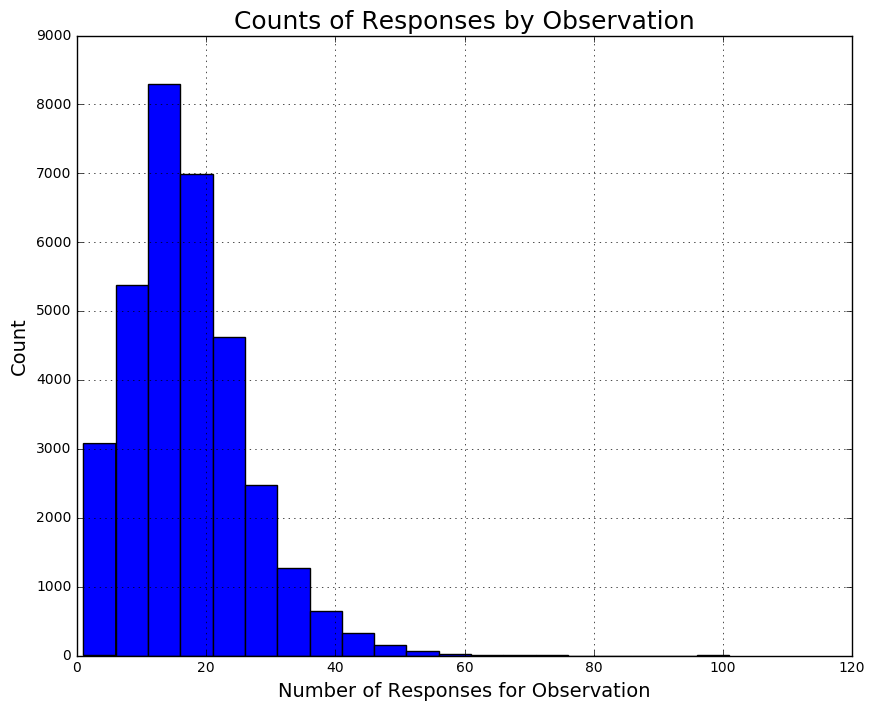

In [28]:
plt.figure(figsize=(10,8))
df3.freq.hist(bins=20)
plt.title('Counts of Responses by Observation', fontsize=18)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Number of Responses for Observation', fontsize=14)

In [29]:
df3.day_num.max()

2304

In [13]:
# Create test and trainging sets
df_train = df3[(df3.day_num < 1300) | (df3.day_num > 1600)]
df_test = df3[(df3.day_num >= 1300) & (df3.day_num <= 1600)]

# Create X and y
y_train = df_train.pop('freq')
X_train = df_train
y_test = df_test.pop('freq')
X_test = df_test

# Scale X
# scaler = StandardScaler(with_mean=False)
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [14]:
model = Poisson(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 3.147548
         Iterations 34


In [15]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                   freq   No. Observations:                28632
Model:                        Poisson   Df Residuals:                    28611
Method:                           MLE   Df Model:                           20
Date:                Mon, 14 Nov 2016   Pseudo R-squ.:                  0.3446
Time:                        13:20:37   Log-Likelihood:                -90121.
converged:                       True   LL-Null:                   -1.3751e+05
                                        LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
mariners_home     0.0015      0.003      0.444      0.657        -0.005     0.008
seahawks_home    -0.0296      0.010     -2.864      0.004        -0.050    -0.009
sounders_home     0.0126      0.007      1.782      0.075        -0.001     0.027
trav_holiday     -0.0553      0.011     -4.845      0.000        -0.078    -0.033
dang_holiday      0.1407      0.017      8.086      0.000         0.107     0.175
night             0.2921      0.003     99.652      0.000         0.286     0.298
Monday           -0.0465      0.005     -8.580      0.000        -0.057    -0.036
Saturday          0.0053      0.005      0.974      0.330        -0.005     0.016
Sunday           -0.0106      0.006     -1.898      0.058        -0.022     0.000
Thursday         -0.0351      0.005     -6.502      0.000        -0.046    -0.025
Tuesday          -0.0424      0.005     -7.867      0.000        -0.053    -0.032
Wednesday        -0.0348      0.005     -6.467      0.000        -0.045    -0.024
day_num           0.0001   2.07e-06     69.079      0.000         0.000     0.000
zone1             2.6382      0.006    430.659      0.000         2.626     2.650
zone2             2.4137      0.006    377.934      0.000         2.401     2.426
zone3             2.0130      0.007    288.156      0.000         1.999     2.027
zone4             2.5833      0.006    417.649      0.000         2.571     2.595
zone5             2.9808      0.006    512.984      0.000         2.969     2.992
zone6             2.2049      0.007    330.300      0.000         2.192     2.218
zone7             2.3588      0.006    365.252      0.000         2.346     2.372
seasonality       0.0519      0.002     23.996      0.000         0.048     0.056
=================================================================================
"""

In [27]:
y_hat = model.predict(X_test) 

In [28]:
mean_squared_error(y_test, y_hat)

24.313549254315017

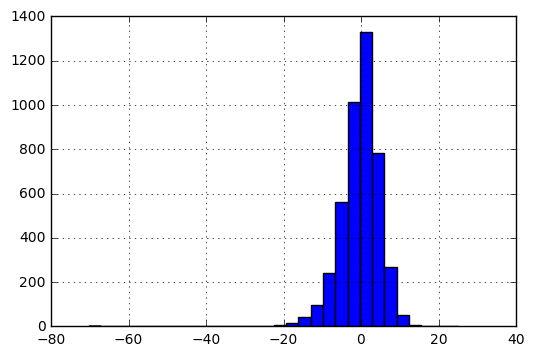

In [33]:
differences = y_hat - y_test
differences.hist(bins=30)

In [55]:
model_reg1 = Poisson(y_train, X_train).fit_regularized(method='l1', alpha=201)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.1476107618
            Iterations: 216
            Function evaluations: 227
            Gradient evaluations: 216
QC check did not pass for 9 out of 21 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.


In [56]:
model_reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                   freq   No. Observations:                28632
Model:                        Poisson   Df Residuals:                    28611
Method:                           MLE   Df Model:                           20
Date:                Mon, 14 Nov 2016   Pseudo R-squ.:                  0.3446
Time:                        13:50:58   Log-Likelihood:                -90121.
converged:                       True   LL-Null:                   -1.3751e+05
                                        LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
mariners_home     0.0015      0.003      0.444      0.657        -0.005     0.008
seahawks_home    -0.0296      0.010     -2.863      0.004        -0.050    -0.009
sounders_home     0.0126      0.007      1.781      0.075        -0.001     0.027
trav_holiday     -0.0553      0.011     -4.844      0.000        -0.078    -0.033
dang_holiday      0.1407      0.017      8.084      0.000         0.107     0.175
night             0.2921      0.003     99.652      0.000         0.286     0.298
Monday           -0.0465      0.005     -8.577      0.000        -0.057    -0.036
Saturday          0.0053      0.005      0.977      0.329        -0.005     0.016
Sunday           -0.0106      0.006     -1.895      0.058        -0.022     0.000
Thursday         -0.0351      0.005     -6.498      0.000        -0.046    -0.025
Tuesday          -0.0424      0.005     -7.864      0.000        -0.053    -0.032
Wednesday        -0.0347      0.005     -6.464      0.000        -0.045    -0.024
day_num           0.0001   2.07e-06     69.081      0.000         0.000     0.000
zone1             2.6382      0.006    430.653      0.000         2.626     2.650
zone2             2.4137      0.006    377.929      0.000         2.401     2.426
zone3             2.0129      0.007    288.152      0.000         1.999     2.027
zone4             2.5833      0.006    417.644      0.000         2.571     2.595
zone5             2.9807      0.006    512.979      0.000         2.969     2.992
zone6             2.2049      0.007    330.296      0.000         2.192     2.218
zone7             2.3588      0.006    365.247      0.000         2.346     2.371
seasonality       0.0519      0.002     23.998      0.000         0.048     0.056
=================================================================================
"""

In [57]:
y_hat_reg1 = model_reg1.predict(X_test) 

In [58]:
mean_squared_error(y_test, y_hat_reg1)

24.313438578191683

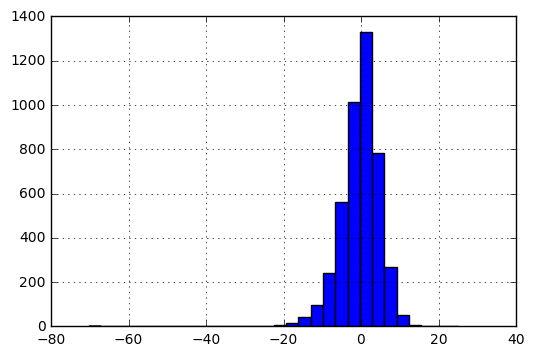

In [59]:
differences_reg1 = y_hat_reg1 - y_test
differences_reg1.hist(bins=30)

In [45]:
'''
Questions:
1. Scaling not required?
2. Dep Variable freq vs count?
3. Refactor day in 12 hr rather than 24 hr?
'''

In [19]:
model_boosting = GradientBoostingRegressor(subsample=0.5, n_estimators=10000, learning_rate=0.001)

In [20]:
model_boosting.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.001,
             loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10000,
             presort='auto', random_state=None, subsample=0.5, verbose=0,
             warm_start=False)

In [21]:
y_hat_boost = model_boosting.predict(X_test)

In [22]:
mean_squared_error(y_test, y_hat_boost)

30.693052991046358

In [23]:
model_forest = RandomForestRegressor(n_jobs=-1, n_estimators=1000, max_features='sqrt')

In [24]:
model_forest.fit(X_train, y_train, )

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=-1, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [25]:
y_hat_for = model_forest.predict(X_test)

In [26]:
mean_squared_error(y_test, y_hat_for)

26.096926519196025